In [1]:
!pip install opencv-python

In [2]:
import cv2
import os.path
import matplotlib.pyplot as plt
import numpy as np
import glob

In [3]:
source_path = './anaselmasry/source'
positive_path = os.path.join(source_path, 'positive_Covid-19')
negative_path = os.path.join(source_path, 'negative_Covid-19')
default_negative_filename = os.path.join(negative_path, 'negative_0_641.jpg')
default_positive_filename = os.path.join(positive_path, 'positive_0_4741.jpg')
target_path = './anaselmasry/processed'
target_positive_path = os.path.join(target_path, 'positive_Covid-19')
target_negative_path = os.path.join(target_path, 'negative_Covid-19')


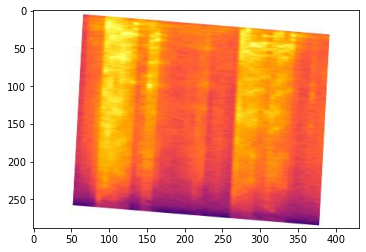

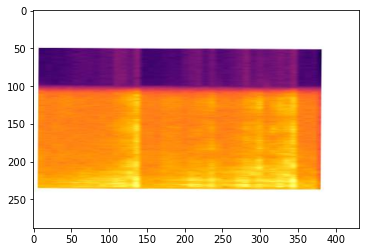

In [4]:
def loadImgRGB(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
negative_img = loadImgRGB(default_negative_filename)
positive_img = loadImgRGB(default_positive_filename)
plt.figure()
plt.imshow(negative_img)
plt.figure()
plt.imshow(positive_img)


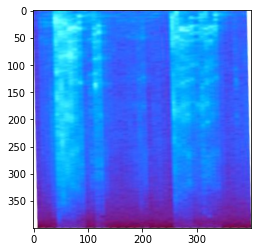

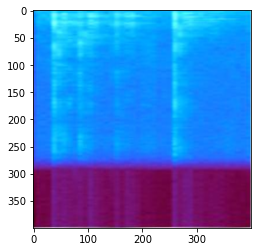

In [7]:
def loadImgGray(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def findContours(filename):
    img = loadImgGray(filename)
    ret, thr = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
    contours, hier = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def findBestContour(filename):
    contours = findContours(filename)
    best = None
    bestArea = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if (area > bestArea):
            bestArea = area
            best = contour
    return best

def getCorrectedImg(filename):
    img = cv2.imread(filename)
    contour = findBestContour(filename)
    rect = cv2.minAreaRect(contour)
    srcBox = cv2.boxPoints(rect)
    tgtBox = np.float32([[0, 400], [0, 0], [400, 0], [400, 400]])
    transform = cv2.getPerspectiveTransform(srcBox, tgtBox)
    return cv2.warpPerspective(img, transform, (400, 400))


def getRotatedImg(filename):
    img = getCorrectedImg(filename)
    top = np.sum(img[:50, :])
    bottom = np.sum(img[350:, :])
    left = np.sum(img[:, :50])
    right = np.sum(img[:, 350:])
    img_min = min(top, bottom, left, right)
    if img_min == top:
        return cv2.rotate(img, cv2.ROTATE_180)
    elif img_min == bottom:
        return img
    elif img_min == left:
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif img_min == right:
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

negative_rotated = getRotatedImg(default_negative_filename)
positive_rotated = getRotatedImg(default_positive_filename)
plt.figure()
plt.imshow(negative_rotated)
plt.figure()
plt.imshow(positive_rotated)

In [6]:
os.makedirs(target_positive_path, exist_ok = True)
os.makedirs(target_negative_path, exist_ok = True)

for filename in glob.iglob(positive_path + '/**/*.jpg', recursive=True):

    path = os.path.normpath(filename)
    tokens = path.split(os.sep)
    save_path = os.path.join(target_positive_path, tokens[len(tokens) - 1])
    img = getRotatedImg(filename)
    cv2.imwrite(save_path, img)

for filename in glob.iglob(negative_path + '/**/*.jpg', recursive=True):
    path = os.path.normpath(filename)
    tokens = path.split(os.sep)
    save_path = os.path.join(target_negative_path, tokens[len(tokens) - 1])
    img = getRotatedImg(filename)
    cv2.imwrite(save_path, img)